In [1]:
# pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress warnings from pandas
import warnings
warnings.filterwarnings('ignore')

# Collection of helper functions for aggregation
import featuregen.featuregeneration as fg

from sklearn.linear_model import LinearRegression as LR 
# (fit_intercept=True, normalize=False, copy_X=True, n_jobs=1)

plt.style.use('fivethirtyeight')

# Memory management
import gc 

% matplotlib inline 

## Load data
##### (Note: `data/` subdirectory holds all input and output data)
#### Specify:
* input and output files
* minimum TARGET correlation to consider
* maximum acceptable fraction of NaNs in any column

In [2]:
# Base filename
filename = 'application_train'
colPref = 'APP_TRAIN'
corrThresh = 0.002
colNApctThresh = .2
filenameOtherThanApplication_train = filename != 'application_train'

In [3]:
infile = 'data/'+filename+'.csv'
outfile = "data/"+filename+"_all_columns_imputed_by_category_cohort.csv"
goodTARGETcorrFile = "data/"+filename+"high_corr_columns_imputed_by_category_cohort.csv"

In [4]:
try:
    df is None
except NameError:
    df = pd.read_csv(infile)
    df = fg.convert_types(df, print_info=True)

Original Memory Usage: 0.3 gb.
New Memory Usage: 0.17 gb.


#### We need `application_train` data set for the `TARGET` value

In [5]:
if filenameOtherThanApplication_train:
    try:
        application_train is None
    except NameError:
        application_train = pd.read_csv('data/application_train.csv')
        application_train = fg.convert_types(application_train, print_info=True)
else:
    application_train = df

### Examine data
#### Look at NaN counts in columns and choose columns to keep

Text(0,0.5,'Number of remaining columns')

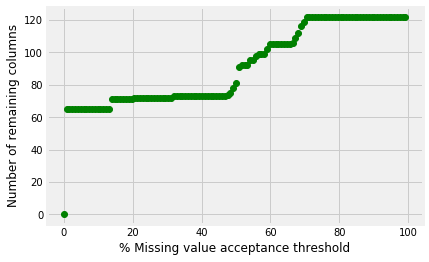

In [6]:
largely_null_columns = df.isnull().sum() / df.isnull().count()
x = [(1/len(largely_null_columns))* i for i,r in enumerate(largely_null_columns)]
y = [(largely_null_columns < i).sum()  for i in x]
plt.plot([100*xx for xx in x],y,'go')
plt.xlabel("% Missing value acceptance threshold")
plt.ylabel("Number of remaining columns")

In [7]:
df.columns

Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY',
       ...
       'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20',
       'FLAG_DOCUMENT_21', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object', length=122)

In [8]:
df_reduced = df[[c for c in df.columns if df[c].isnull().sum()/df[c].isnull().count() < colNApctThresh ]]

#### Number of columns dropped

In [12]:

len(df.columns) - len(df_reduced.columns)

50

#### If you want to drop the 'largely NaN' columns, then use `df_reduced` instead of `df` in what follows.

## One-hot encode categorical columns
#### Create column with categorical cohort vector, 'UNIQ_FEAT_COMB'  for subsequent NaN imputation

In [13]:
df_dum = pd.get_dummies(df_reduced.select_dtypes('category'))
df_dum["UNIQ_FEAT_COMB"] = ["".join([str(rr) for rr in r]) for r in df_dum.values]

In [14]:
df_dum.shape

(307511, 107)

In [15]:
df_dum.columns

Index(['NAME_CONTRACT_TYPE_Cash loans', 'NAME_CONTRACT_TYPE_Revolving loans',
       'CODE_GENDER_F', 'CODE_GENDER_M', 'CODE_GENDER_XNA', 'FLAG_OWN_CAR_N',
       'FLAG_OWN_CAR_Y', 'FLAG_OWN_REALTY_N', 'FLAG_OWN_REALTY_Y',
       'NAME_TYPE_SUITE_Children',
       ...
       'ORGANIZATION_TYPE_Trade: type 5', 'ORGANIZATION_TYPE_Trade: type 6',
       'ORGANIZATION_TYPE_Trade: type 7',
       'ORGANIZATION_TYPE_Transport: type 1',
       'ORGANIZATION_TYPE_Transport: type 2',
       'ORGANIZATION_TYPE_Transport: type 3',
       'ORGANIZATION_TYPE_Transport: type 4', 'ORGANIZATION_TYPE_University',
       'ORGANIZATION_TYPE_XNA', 'UNIQ_FEAT_COMB'],
      dtype='object', length=107)

#### Add the numeric columns back into the datafraame

In [16]:
df_num_and_dum = pd.concat([df.select_dtypes("number"),df_dum],axis=1)

#### Save the dataframe with dummies

In [ ]:
df_num_and_dum.to_csv("data/"+filename+"_df_num_and_dum.csv")

In [ ]:
try:
    df_num_and_dum is None
except NameError:
    df_num_and_dum = pd.read_csv("data/"+filename+"_df_num_and_dum.csv")

In [ ]:
df_num_and_dum.columns

## Impute NaNs by categorical cohort
#### Get the numeric columns, and omit the ID columns

In [ ]:
nonIDcols = [cc for cc in df.select_dtypes("number").columns if not "SK" in cc and not "TARGET" in cc]
nonIDcols

#### Group by identical categorical cohort and impute NaNs within group
##### (Thank you, JPFGM team!)

In [ ]:
df_num_and_dum[nonIDcols] = df_num_and_dum[nonIDcols+['UNIQ_FEAT_COMB']].groupby("UNIQ_FEAT_COMB").transform(lambda x:x.fillna(x.mean()))
df_num_and_dum.head()

In [ ]:
df_num_and_dum.columns

## Generate the aggregated features
#### Group by `SK_ID_CURR`...
#### ...Aggregate...
#### ...Flatten the column names and make them upper case

In [ ]:
df_agg_num_and_dum = df_num_and_dum[nonIDcols+["SK_ID_CURR"]].groupby("SK_ID_CURR").agg(["size","mean","min","max"])
df_agg_num_and_dum.columns = ['_'.join(c).upper() for c in df_agg_num_and_dum.columns]

#### Append all the application_train columns.  
If you are using  `application_train`  in the first place, then just append the `TARGET` column.


In [ ]:
if filenameOtherThanApplication_train:
    df_agg_target = application_train.join(df_agg_num_and_dum, how='left', on="SK_ID_CURR")
else:
    df_agg_target["TARGET"] = application_train["TARGET"]

In [ ]:
"TARGET" in df_agg_target.columns

In [ ]:
df_agg_target.shape

#### Save the imputed data set

In [ ]:
df_agg_target.to_csv(outfile)

## Further analysis
#### Remind ourselves of class imbalance....

In [ ]:
df_agg_target["TARGET"].hist()

#### Select columns based on threshold for correlation to TARGET

In [ ]:
corrs = df_agg_target.corr()["TARGET"].sort_values()
maxPosCor = corrs.tail(10)
maxNegCor = corrs.head(10)
corrCols = maxNegCor.to_frame().append(maxPosCor.to_frame()).query("TARGET > @corrThresh or TARGET < -@corrThresh ").index
corrCols = list(corrCols)
df_corrCols_bool = [c in corrCols for c in df_agg_target.columns]
df_corrCols = df_agg_target.columns[df_corrCols_bool]
df_corrCols

In [ ]:
df_agg_target_corr = df_agg_target[df_corrCols]
df_agg_target_corr.shape

#### Final columns with sufficient correlation to `TARGET`

In [ ]:
goodCorrCols = [c for c in  df_agg_target_corr.columns if not c in ["TARGET"]]
goodCorrCols

In [ ]:
len(goodCorrCols)

#### Examine density functions

In [ ]:
for c in goodCorrCols:
    fg.kde_target(c, df_agg_target_corr)

### Save file with columns having acceptable correlation to `TARGET`

In [ ]:
df_agg_target_corr.to_csv(goodTARGETcorrFile)